# Read_Me
- Recommended python >= 3.7
-  PyTorch 2.0+ 

In [1]:
from __future__ import annotations
import os, time, random                          # built-in Python utilities
from pathlib import Path                         # nice object for filesystem paths
from typing import Dict, Tuple, Optional

import matplotlib.pyplot as plt
import numpy as np                               # maths library (arrays)
import torch                                     # the main deep-learning library
import torch.nn as nn                            # “nn” = neural-network layers
import torch.optim as optim                      # optimisers (SGD, Adam, …)
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import OneCycleLR  # learning-rate scheduler
from torch.utils.data import (
    DataLoader, random_split, Subset)            # dataset helpers
from torchvision import (
    datasets, models, transforms)                # ready-made datasets, models, image tools

In [2]:
# Hyper-parameters
SEED               = 42          # fixed random-seed → reproducible run
DATA_DIR           = Path("data/food101")
BATCH_SIZE         = 128          # images per mini-batch
NUM_EPOCHS_PHASE1  = 10 # 10          # train the new classifier head
NUM_EPOCHS_PHASE2  = 8 # 6           # optional fine-tune of backbone
LR_HEAD            = 4e-3        # learning-rate for head
LR_BACKBONE        = 4e-4        # lower LR when we unfreeze backbone
PATIENCE           = 3           # early-stop if no val-improve for N epochs
NUM_WORKERS        = 3           # CPU processes that feed images
CKPT_DIR           = Path("checkpoints")  # where to save model checkpoints during training
CKPT_DIR.mkdir(parents=True, exist_ok=True)  # create that folder if missing

In [3]:
# Reproducibility
def set_seed(seed: int) -> None:
    random.seed(seed)                  # vanilla Python Random Number Generator (RNG)
    np.random.seed(seed)               # NumPy RNG
    torch.manual_seed(seed)            # CPU-side torch RNG
    torch.cuda.manual_seed_all(seed)   # all GPU RNGs
    # torch.backends.cudnn.deterministic = True  # force deterministic conv kernels
    # torch.backends.cudnn.benchmark = False     # trade speed for reproducibility
set_seed(SEED)
print(f"Setting seed: {SEED}")

Setting seed: 42


I previously forced determinism (good for reproducibility) but it prevents CuDNN from picking its fastest kernels. Therefore removed bottom two booleans.

In [4]:
# Choose device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {DEVICE}")

Using: cuda


In [5]:
# Image Transforms
IMG_SIZE = 224 # final height/width

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),    # random crop + resize (data-aug)
    transforms.RandomHorizontalFlip(),         # 50 % mirror (data-aug)
    transforms.ToTensor(),                     # H×W×C → C×H×W in [0,1]
    transforms.Normalize([0.485,0.456,0.406],  # ImageNet distribution
                         [0.229,0.224,0.225])
])
val_tfms = transforms.Compose([
    transforms.Resize(256),                    # shrink so short edge=256
    transforms.CenterCrop(IMG_SIZE),           # take middle 224×224 window
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],  # ImageNet distribution
                         [0.229,0.224,0.225])
])

For validation, we first `Resize` the image to 256 before `CenterCrop`, because we would like to consistenly capture most of the image. Unless we use `Resize`, images smaller than 224 px width and height will raise an error, while very small portions of large images would be cut out. Therefore, `Resize` is an important step before croping the center.

In [6]:
# Download + split dataset into train, val, test sets
print("Downloading Food-101 Dataset…")
full_train = datasets.Food101(root=DATA_DIR, split="train", 
                              transform=train_tfms, download=True)
test_set =   datasets.Food101(root=DATA_DIR, split="test", 
                              transform=val_tfms, download=True)

train_len = int(0.8 * len(full_train)) # 80 %
val_len = len(full_train) - train_len # 20 %

train_set, val_tmp = random_split(
    full_train,
    lengths=[train_len, val_len],
    generator=torch.Generator().manual_seed(SEED) # reproducible indices
)

val_set = Subset(
    datasets.Food101(root=DATA_DIR, split="train", transform=val_tfms, download=True),
    val_tmp.indices # reuse exact same images but w/ val transforms
)

100%|██████████| 5.00G/5.00G [03:34<00:00, 23.3MB/s]


In [7]:
loaders = {
    "train": DataLoader(train_set, batch_size=BATCH_SIZE,
                       shuffle=True, num_workers=NUM_WORKERS, pin_memory=True),
    "val":   DataLoader(val_set, batch_size=BATCH_SIZE,
                       shuffle=True, num_workers=NUM_WORKERS, pin_memory=True),
    "test":  DataLoader(test_set, batch_size=BATCH_SIZE,
                       shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
}
class_names = full_train.classes
print(f"Data ready. len(train)={len(train_set)}, len(val)={len(val_set)}, len(test)={len(test_set)}")

Data ready. len(train)=60600, len(val)=15150, len(test)=25250


`num_workers` tells PyTorch how many separate CPU processes to use for loading and preprocessing data in parallel. You can use less workers for easier developing (2-4) and debugging (0), but use 4, 6, or 8 depending on your CPU worker number for serious training runs.

When `pin_memory=True`, PyTorch can use a faster path to move data from CPU to GPU. This can give a small but meaningful speed boost during training, but does not help when training only on CPU.

## Test Different CPU Worker Speeds

In [8]:
import os
print(os.cpu_count()) # check your CPU worker number

4


In [9]:
# Training loader
test_num_workers = 4

train_loader = DataLoader(
    train_set,
    batch_size=64,
    shuffle=True,
    num_workers=test_num_workers,
    pin_memory=True
)

import time
start = time.time()
for i, batch in enumerate(train_loader):
    if i == 10: break  # just test 10 batches
print(f"Time for 10 batches: {time.time() - start:.2f}s. Using {test_num_workers} cpu workers.")

Time for 10 batches: 2.58s. Using 4 cpu workers.


In [10]:
# Create the model
def build_model(num_classes: int) -> nn.Module:
    model = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1)
    for p in model.parameters():
        p.requires_grad = False # freeze all backbone layers
    in_features = model.classifier[1].in_features # incoming dims to classifier
    model.classifier[1] = nn.Linear(in_features, num_classes) # new classifier head
    return model.to(DEVICE)

model = build_model(len(class_names))

# try compile if supported:
if DEVICE.type == "cuda" and torch.cuda.is_available():
    cap = torch.cuda.get_device_properties(DEVICE).major
    if cap >= 7:
        model = torch.compile(model)
    else:
        print(f"GPU CC {cap}.x detected – skipping torch.compile()")
        
criterion = nn.CrossEntropyLoss() # standard multi-class loss

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 88.5MB/s]


GPU CC 6.x detected – skipping torch.compile()


We load EfficientNet-B2 pretrained on ImageNet. EfficientNet-B2 is the sweet spot: under 10 M parameters and just ~1 GFLOP. You’ll get very fast per-batch times on a P100, low memory use, and still close to 81 % top-1 on ImageNet—so fine-tuned on Food-101 you can expect strong performance in a few epochs.
Freeze it → only the new final layer learns at first.

In [11]:
# Utility
scaler = GradScaler()

def epoch_loop (phase: str, 
                model: nn.Module, 
                loader: DataLoader, 
                optimizer: Optional[torch.optim.Optimizer] = None,
                scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None,
                epoch_idx: int = 0
               ) -> Tuple[float, float]:
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    run_loss, run_correct, imgs_processed = 0.0, 0, 0
    t0 = time.time()

    with torch.set_grad_enabled(is_train):
        for x, y in loader:                           # mini-batch loop
            optimizer.zero_grad(set_to_none=True) if is_train else None # saves a bit of GPU memory
            
            x, y = x.to(DEVICE,non_blocking=True), y.to(DEVICE,non_blocking=True)

            with autocast("cuda"):
                outputs = model(x)                    # forward pass
                loss = criterion(outputs, y)

            if is_train:
                scaler.scale(loss).backward()         # back-prop                
                
                # --- gradient clipping ---
                scaler.unscale_(optimizer)            # un-scale the gradients that live on the model (needed for gradient clipping)
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                scaler.step(optimizer)                # update params
                scaler.update()                       # update scale factor    
                if scheduler is not None:             # LR scheduler
                    scheduler.step()

            batch_size = x.shape[0]
            run_loss += loss.item()*batch_size        # accumulate summed loss
            run_correct += (outputs.argmax(1) == y).sum().item()
            imgs_processed += batch_size              # add to throughput counter

    torch.cuda.synchronize()                          # CPU waits until GPU finishes. More accurate dt.
    dt = time.time() - t0                             # total epoch time in seconds
    epoch_loss = run_loss / len(loader.dataset) 
    epoch_acc = run_correct / len(loader.dataset)
    throughput = imgs_processed / dt
    print(f"{phase:5} | loss {epoch_loss:.4f} | acc {epoch_acc:.4f} | {dt:5.1f}s | {throughput:7.1f} samples/s")
    
    if is_train:                                      # train phase only
        print(f"[Epoch {epoch_idx}] loss_scale={scaler.get_scale():.0f}  peak_mem={torch.cuda.max_memory_allocated()/1024**2:.0f} MB")
        torch.cuda.reset_peak_memory_stats()          # so next epoch starts fresh
        
    return epoch_loss, epoch_acc

One function that handles both train (updates weights) and val/test (no grads).

`torch.set_grad_enabled(False)` saves GPU RAM when evaluating. It is the same as `torch.no_grad`.

`non_blocking=True` provides a subtle performance optimization when we set `pin_memory=True` in our `DataLoader`, which we already did. This allows the CPU to continue preparing the next batch while the current batch is being transferred to the GPU.

Using `set_to_none=True` is optional, but it avoids writing zeros to every
gradient tensor and can speed up large models.

If you’re on GPU, kernels are asynchronous. Calling
`torch.cuda.synchronize()` right before timing will make `dt` slightly more exact (at the cost of a tiny stall).

`clip_grad_norm_` calculates global norm of the params, make sure that its length is no more than 1.0 (clip it), this helps prevent "shocking" the model when the loss (and thus the gradients) become too big for an unlucky batch.

Why bother clipping?
- Prevents exploding activations when a single bad mini-batch produces huge gradients.
- Makes training more stable when you crank up the learning rate for large batches.
- Adds almost zero overhead (one extra kernel).

In [12]:
# Checkpoint helper
def save_ckpt(state: Dict, name: str) -> None:
    torch.save(state, CKPT_DIR / name)

In [13]:
# 0) Before any training, create your metric containers:
train_losses, train_accs = [], []
val_losses,   val_accs   = [], []

In [14]:
# Phase 1: feature extraction (freeze backbone, train only the new head)
optimizer = optim.Adam(model.classifier[1].parameters(), lr=LR_HEAD)

steps_per_epoch = len(loaders["train"]) # how many batches per epoch
total_steps = NUM_EPOCHS_PHASE1 * steps_per_epoch

scheduler = OneCycleLR(
    optimizer,
    max_lr=LR_HEAD,
    total_steps=total_steps,
    pct_start=0.3,            # 30% of total steps for LR warm-up
    anneal_strategy="cos",    # cosine annealing down
)

best_val, patience_cnt = 1e9, 0

print("Phase 1: feature extraction")
for epoch in range(1, NUM_EPOCHS_PHASE1+1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS_PHASE1}")
    train_loss, train_acc = epoch_loop("train", model, loaders["train"], 
                                       optimizer, scheduler, epoch)
    val_loss, val_acc = epoch_loop("val", model, loaders["val"])

    # track metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    if val_loss < best_val:          # improved → save
        best_val, patience_cnt = val_loss, 0
        save_ckpt({
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
            "scaler": scaler.state_dict(),
            "epoch": epoch,
            "val_acc": val_acc
        }, "best_head.pth")
    else:                            # no improve
        patience_cnt += 1
        if patience_cnt >= PATIENCE:
            print("Early stop triggered.")
            break
    

Phase 1: feature extraction

Epoch 1/10
train | loss 3.8938 | acc 0.2189 | 133.4s |   454.4 samples/s
[Epoch 1] loss_scale=65536  peak_mem=759 MB
val   | loss 2.7146 | acc 0.4365 |  37.6s |   403.1 samples/s

Epoch 2/10
train | loss 2.6651 | acc 0.3891 | 131.4s |   461.3 samples/s
[Epoch 2] loss_scale=65536  peak_mem=759 MB
val   | loss 2.0618 | acc 0.5004 |  38.0s |   398.4 samples/s

Epoch 3/10
train | loss 2.5446 | acc 0.4034 | 130.4s |   464.8 samples/s
[Epoch 3] loss_scale=65536  peak_mem=759 MB
val   | loss 2.0524 | acc 0.4986 |  38.0s |   398.9 samples/s

Epoch 4/10
train | loss 2.5759 | acc 0.4056 | 138.5s |   437.5 samples/s
[Epoch 4] loss_scale=65536  peak_mem=759 MB
val   | loss 1.9898 | acc 0.5114 |  38.6s |   392.3 samples/s

Epoch 5/10
train | loss 2.5644 | acc 0.4089 | 133.0s |   455.5 samples/s
[Epoch 5] loss_scale=131072  peak_mem=759 MB
val   | loss 1.9726 | acc 0.5191 |  37.5s |   404.0 samples/s

Epoch 6/10
train | loss 2.5206 | acc 0.4189 | 130.1s |   465.7 samples

Classic training loop + early-stop: if validation loss stalls for 3 epochs, quit.

At the start of training, a high learning rate helps you learn fast. Later, you want to reduce it so the model converges more smoothly and doesn’t overshoot.

`loss_scale`:
- Starts high (32 k–65 k) – normal.
- Occasionally halves – AMP detected an overflow, skipped that update, and lowered the scale.
- Oscillates between two values – healthy adaptation.
- Keeps shrinking to 1 – lots of overflows → reduce LR, batch size, or use gradient clipping.

In [15]:
# del model
# import gc
# gc.collect()

# import torch
# torch.cuda.empty_cache()

In [16]:
# Phase 2: fine-tune (unfreeze backbone, train whole model at lower LR)
print("\n Unfreezing backbone...")
for p in model.parameters():
    p.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=LR_BACKBONE)

steps_per_epoch = len(loaders["train"]) # how many batches per epoch
total_steps = NUM_EPOCHS_PHASE2 * steps_per_epoch

scheduler = OneCycleLR(
    optimizer,
    max_lr=LR_BACKBONE,
    total_steps=total_steps,
    pct_start=0.3,
    anneal_strategy="cos",
)

print("Phase 2: fine-tune")
for epoch in range(1, NUM_EPOCHS_PHASE2+1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS_PHASE2}")
    train_loss, train_acc = epoch_loop("train", model, loaders["train"], 
                                       optimizer, scheduler, epoch)
    val_loss, val_acc = epoch_loop("val", model, loaders["val"])

    # track metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    save_ckpt({
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
            "scaler"     : scaler.state_dict(),
            "epoch": epoch,
            "val_acc": val_acc
    }, f"ft_epoch{epoch}.pth")




 Unfreezing backbone...
Phase 2: fine-tune

Epoch 1/8


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train | loss 1.9177 | acc 0.5274 | 249.8s |   242.6 samples/s
[Epoch 1] loss_scale=32768  peak_mem=8151 MB
val   | loss 1.2161 | acc 0.6856 |  39.2s |   386.1 samples/s

Epoch 2/8
train | loss 1.4374 | acc 0.6346 | 249.5s |   242.9 samples/s
[Epoch 2] loss_scale=32768  peak_mem=8151 MB
val   | loss 0.9791 | acc 0.7416 |  38.0s |   398.4 samples/s

Epoch 3/8
train | loss 1.2228 | acc 0.6806 | 250.0s |   242.4 samples/s
[Epoch 3] loss_scale=32768  peak_mem=8151 MB
val   | loss 0.8701 | acc 0.7685 |  38.5s |   393.1 samples/s

Epoch 4/8
train | loss 1.0308 | acc 0.7290 | 250.0s |   242.4 samples/s
[Epoch 4] loss_scale=32768  peak_mem=8151 MB
val   | loss 0.7902 | acc 0.7955 |  38.3s |   395.6 samples/s

Epoch 5/8
train | loss 0.8710 | acc 0.7687 | 249.8s |   242.6 samples/s
[Epoch 5] loss_scale=32768  peak_mem=8151 MB
val   | loss 0.7433 | acc 0.8118 |  38.1s |   397.7 samples/s

Epoch 6/8
train | loss 0.7266 | acc 0.8044 | 249.9s |   242.5 samples/s
[Epoch 6] loss_scale=32768  peak_mem=8

We now let all layers learn but at a smaller LR to avoid wrecking pretrained features.

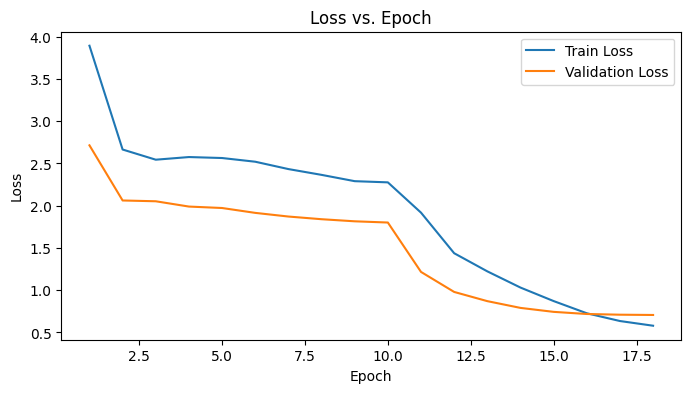

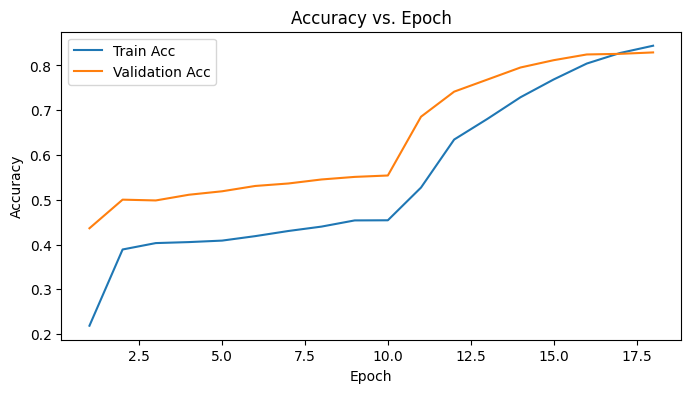

In [17]:
# plot curves
epochs = list(range(1, len(train_losses)+1))
# epochs = [1, 2, 3]
# train_losses, train_accs = [9, 8, 2], [5, 4, 2]
# val_losses,   val_accs   = [12, 10, 5], [7, 4, 1]

plt.figure(figsize=(8,4))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs. Epoch")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs,   label="Validation Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs. Epoch")
plt.show()

In [18]:
# Final test
model.eval()
_, test_acc = epoch_loop("test", model, loaders["test"])
print(f"Final Test Acc: {test_acc:.4f}")

test  | loss 0.4774 | acc 0.8672 |  63.1s |   399.9 samples/s
Final Test Acc: 0.8672


Turn off training mode, run once on the held-out test set → final score.